Nbr de vehicules 4
Capacité des vehicules [15, 15, 15, 15]
Route for vehicle 0:
 0 Load(0) ->  1 Load(1) ->  4 Load(5) ->  3 Load(7) ->  15 Load(15) ->  0 Load(15)
Distance of the route: 2192m
Load of the route: 15

Route for vehicle 1:
 0 Load(0) ->  14 Load(4) ->  16 Load(12) ->  10 Load(14) ->  2 Load(15) ->  0 Load(15)
Distance of the route: 2192m
Load of the route: 15

Route for vehicle 2:
 0 Load(0) ->  7 Load(8) ->  13 Load(12) ->  12 Load(14) ->  11 Load(15) ->  0 Load(15)
Distance of the route: 1324m
Load of the route: 15

Route for vehicle 3:
 0 Load(0) ->  9 Load(1) ->  8 Load(9) ->  6 Load(13) ->  5 Load(15) ->  0 Load(15)
Distance of the route: 1164m
Load of the route: 15



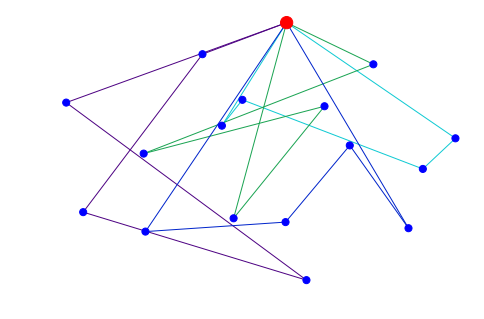

Total distance of all routes: 6872m
Total load of all routes: 60


In [42]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import math
import sys
import json

def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['demands'] = [0, 1, 1, 2, 4, 2, 4, 8, 8, 1, 2, 1, 2, 4, 4, 8, 8]
    data['vehicle_capacities'] = [15, 15, 15, 15]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data


# On affiche les resultat de la fonctions
def print_solution(data, manager, routing, assignment, numpy_matrix):
    """Prints assignment on console."""
    total_distance = 0
    total_load = 0
    edge_liste = []
    edge_start = 0
    taille_matrix = len(numpy_matrix)
    G = nx.path_graph(taille_matrix)
    G = nx.from_numpy_matrix(numpy_matrix)
    position = nx.spring_layout(G)
    G = nx.from_numpy_matrix(numpy_matrix)
    color=[]
    size=[]
    for node in G:
        if node == 0:
            color.append('r')
            size.append(150)
        else: 
            color.append('b')
            size.append(50)
    G = nx.create_empty_copy(G, False)
    nx.draw(G,node_color=color, pos=position, node_size = size)
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            if node_index != edge_start:
                edge_end = node_index
                edge_liste.append((edge_start, node_index))
                edge_start = node_index
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        if edge_liste != []:
            edge_liste.append((edge_start,0))
            r = lambda: random.randint(0,255)
            color = '#%02X%02X%02X' % (r(),r(),r())
            nx.draw_networkx_edges(G, pos=position, edgelist=edge_liste, edge_color=color)
            edge_liste=[]
            edge_start = 0
        plan_output += ' {0} Load({1})\n'.format(
            manager.IndexToNode(index), route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
        
    plt.show()
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))


def main(argv):
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    numpy_matrix = np.matrix(data['distance_matrix'])
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']), data['num_vehicles'], data['depot'])
    
    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30
    search_parameters.log_search = True

    # Solve the problem.
    assignment = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if assignment:
        print('Nbr de vehicules {}'.format(data['num_vehicles']))
        print('Capacité des vehicules {}'.format(data['vehicle_capacities']))
        print_solution(data, manager, routing, assignment,numpy_matrix)
        


if __name__ == '__main__':
    main(sys.argv[1:])